In [1]:
import os
import random
import numpy as np
from dataclasses import dataclass, field
from typing import Optional, Dict, Any


In [2]:
# reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [3]:
# Hiperparámetros
EPOCHS = 1
BATCH_SIZE = 8
LR = 2e-5
MAX_LEN = 64
OUTPUT_DIR = "outputs_task2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Modelos base
MODEL_ROBERTA = "roberta-base"
MODEL_DEBERTA = "microsoft/deberta-v3-base"
MODERN_BERT_CHECKPOINT = "bert-base-uncased"


In [4]:
# Dependencias
from datasets import load_dataset, ClassLabel, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# 1️⃣ Cargar AG News
dataset = load_dataset("ag_news")  # train=120000, test=7600


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Unir train+test y crear 70/15/15
combined = concatenate_datasets([dataset["train"], dataset["test"]])
combined = combined.shuffle(seed=SEED)
total_n = len(combined)
train_n = int(0.70 * total_n)
val_n = int(0.15 * total_n)
test_n = total_n - train_n - val_n

train_ds = combined.select(range(0, train_n))
val_ds = combined.select(range(train_n, train_n + val_n))
test_ds = combined.select(range(train_n + val_n, total_n))

agnews = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

In [7]:
# Distribución
def label_counts(ds):
    df = ds.to_pandas()
    return df['label'].value_counts().sort_index()
print("Label counts train:", label_counts(agnews["train"]).to_dict())

# 2️⃣ Tokenización
def prepare_tokenizer(checkpoint):
    return AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def tokenize_batch(example, tokenizer):
    return tokenizer(example['text'], truncation=True, padding=False, max_length=MAX_LEN)


Label counts train: {0: 22314, 1: 22452, 2: 22285, 3: 22269}


In [8]:
# 3️⃣ Entrenamiento y evaluación
def train_and_eval(model_checkpoint, dataset_dict, model_name_tag):
    print(f"\n=== Entrenando {model_name_tag} ({model_checkpoint}) ===")

    # Tokenizador
    tokenizer = prepare_tokenizer(model_checkpoint)
    tokenized = dataset_dict.map(lambda x: tokenize_batch(x, tokenizer), batched=True, remove_columns=['text'])
    tokenized = tokenized.map(lambda x: {'labels': x['label']}, batched=True)

    # Modelo
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=4)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # TrainingArguments unificado
    training_args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, model_name_tag),
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        seed=SEED,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        report_to="none"  # desactiva W&B
    )

    # Métricas
    def compute_metrics(pred):
        preds = np.argmax(pred.predictions, axis=1)
        labels = pred.label_ids
        f1_macro = f1_score(labels, preds, average='macro')
        f1_weighted = f1_score(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Entrenamiento
    trainer.train()

    # 🔹 Evaluación final
    test_tokenized = tokenized["test"]
    preds_output = trainer.predict(test_tokenized)
    preds = np.argmax(preds_output.predictions, axis=1)
    true = preds_output.label_ids
    f1_macro = f1_score(true, preds, average='macro')
    f1_weighted = f1_score(true, preds, average='weighted')
    acc = accuracy_score(true, preds)
    report = classification_report(true, preds, target_names=["World","Sports","Business","Sci/Tech"], digits=4)

    results = {
        "model": model_name_tag,
        "checkpoint": model_checkpoint,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
    }

    # Guardar resultados
    pd.DataFrame({"true": true, "pred": preds}).to_csv(os.path.join(OUTPUT_DIR, f"preds_{model_name_tag}.csv"), index=False)
    with open(os.path.join(OUTPUT_DIR, f"metrics_{model_name_tag}.txt"), "w") as f:
        f.write(str(results) + "\n\n")
        f.write(report)

    return results


In [10]:
# 4️⃣ Ejecutar modelos
models_to_run = [
    (MODEL_ROBERTA, "roberta_base"),
    (MODEL_DEBERTA, "deberta_v3_base"),
    (MODERN_BERT_CHECKPOINT, "modern_bert")
]

all_results = []
for ckpt, tag in models_to_run:
    res = train_and_eval(ckpt, agnews, tag)
    print(res)
    all_results.append(res)



=== Entrenando roberta_base (roberta-base) ===


Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2932409859.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.219800,0.221622,0.942633,0.942822,0.942622


{'model': 'roberta_base', 'checkpoint': 'roberta-base', 'accuracy': 0.9417450365726228, 'f1_macro': 0.941998139444366, 'f1_weighted': 0.9417735946343752}

=== Entrenando deberta_v3_base (microsoft/deberta-v3-base) ===


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2932409859.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.220500,0.231546,0.940439,0.940565,0.940397


{'model': 'deberta_v3_base', 'checkpoint': 'microsoft/deberta-v3-base', 'accuracy': 0.9393939393939394, 'f1_macro': 0.9395944427549203, 'f1_weighted': 0.9393526625583689}

=== Entrenando modern_bert (bert-base-uncased) ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2932409859.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.206700,0.207883,0.943051,0.943275,0.943085


{'model': 'modern_bert', 'checkpoint': 'bert-base-uncased', 'accuracy': 0.9408045977011494, 'f1_macro': 0.9410525701018884, 'f1_weighted': 0.9408276923476184}


             model  accuracy  f1_macro  f1_weighted
0     roberta_base  0.941745  0.941998     0.941774
1  deberta_v3_base  0.939394  0.939594     0.939353
2      modern_bert  0.940805  0.941053     0.940828


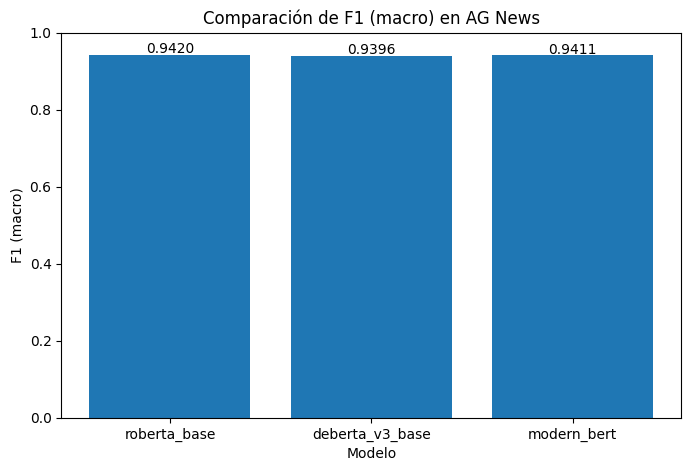


✅ Entrenamiento completo. Resultados guardados en: outputs_task2


In [11]:
# 5️⃣ Resultados y visualización
df_res = pd.DataFrame(all_results)
print(df_res[["model","accuracy","f1_macro","f1_weighted"]])

plt.figure(figsize=(8,5))
plt.bar(df_res['model'], df_res['f1_macro'])
plt.ylabel("F1 (macro)")
plt.xlabel("Modelo")
plt.title("Comparación de F1 (macro) en AG News")
for i, v in enumerate(df_res['f1_macro']):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.ylim(0,1)
plt.savefig(os.path.join(OUTPUT_DIR, "f1_macro_comparison.png"), dpi=150)
plt.show()

df_res.to_csv(os.path.join(OUTPUT_DIR, "summary_results.csv"), index=False)
print("\n✅ Entrenamiento completo. Resultados guardados en:", OUTPUT_DIR)



In [12]:
# 6️⃣ BONUS TASK — LLM + Model Comparison on 50 RPP news items (CSV)
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import f1_score
import torch
import os
import matplotlib.pyplot as plt

In [13]:
# 🔹 1) Cargar CSV de 50 artículos RPP
rpp_csv_path = "src/RPP_50_Articles.csv"
rpp_df = pd.read_csv(rpp_csv_path)
texts_50 = rpp_df['text'].tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'src/RPP_50_Articles.csv'

In [ ]:
# 🔹 2) Clasificación usando LLM
USE_OPENAI = False
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
llm_preds = []

if OPENAI_API_KEY:
    USE_OPENAI = True
    import openai
    openai.api_key = OPENAI_API_KEY

    def classify_with_openai(text):
        prompt = (
            "Classify the following news headline/text into one of these AG News categories:\n"
            "0 - World\n1 - Sports\n2 - Business\n3 - Science/Tech\n\n"
            f"Text: {text}\n\nAnswer with only the category number (0,1,2,3)."
        )
        resp = openai.ChatCompletion.create(
            model="gpt-4o-mini",
            messages=[{"role":"user","content":prompt}],
            max_tokens=5,
            temperature=0
        )
        out = resp['choices'][0]['message']['content'].strip()
        for token in out.split():
            if token.isdigit():
                return int(token)
        try:
            return int(out[0])
        except:
            return 0

    for t in texts_50:
        llm_preds.append(classify_with_openai(t))
else:
    # Fallback: zero-shot HF pipeline
    classifier = pipeline("zero-shot-classification", device=0 if torch.cuda.is_available() else -1)
    candidate_labels = ["World", "Sports", "Business", "Science/Tech"]
    for t in texts_50:
        out = classifier(t, candidate_labels)
        label_map = {"World":0, "Sports":1, "Business":2, "Science/Tech":3}
        llm_preds.append(label_map.get(out['labels'][0], 0))


In [ ]:
# 🔹 3) Clasificación usando tus modelos entrenados
model_preds_50 = {}
for ckpt, tag in models_to_run:
    print(f"\nPredicting with {tag}...")
    model_dir = os.path.join(OUTPUT_DIR, tag)
    tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)

    inputs = tokenizer(texts_50, truncation=True, padding=True, return_tensors="pt")
    if torch.cuda.is_available():
        model = model.cuda()
        inputs = {k:v.cuda() for k,v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
    preds = logits.argmax(dim=1).cpu().numpy()
    model_preds_50[tag] = preds

In [ ]:
# 🔹 4) Evaluar F1 macro vs LLM
comparison = []
for tag, preds in model_preds_50.items():
    f1_m = f1_score(llm_preds, preds, average='macro')
    comparison.append({"model": tag, "f1_macro_vs_LLM": f1_m})

comparison.append({"model": "LLM", "f1_macro_vs_LLM": 1.0})  # LLM vs itself

comp_df = pd.DataFrame(comparison)
print("\n✅ F1 (macro) comparison vs LLM:")
print(comp_df)

In [ ]:
# 🔹 5) Visualización
plt.figure(figsize=(8,4))
plt.bar(comp_df['model'], comp_df['f1_macro_vs_LLM'])
plt.ylabel("F1 (macro) vs LLM")
plt.title("Model predictions vs LLM on 50 RPP news items")
for i, v in enumerate(comp_df['f1_macro_vs_LLM']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.ylim(0,1)
plt.savefig(os.path.join(OUTPUT_DIR, "bonus_f1_vs_llm.png"), dpi=150)
plt.show()

In [ ]:
# 🔹 6) Comentario rápido
print("\n💡 Observaciones:")
print("- Compara los F1 vs LLM para ver qué modelo se alinea mejor con la clasificación del LLM.")
print("- Discrepancias pueden deberse a dominio (AG News vs RPP), longitud de contexto, pretraining, etc.")